In [2]:
import gc
gc.collect()

0

In [1]:
# Import comet_ml at the top of your file
from comet_ml import Experiment

from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
# from gensim.models import KeyedVectors
import swifter
# import itertools


# from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import re
import nltk
# from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
# from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from scipy import stats
from scipy.sparse import coo_matrix, hstack
import seaborn as sns

port_stem = PorterStemmer()

In [2]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)
# data = pd.read_csv("./data.csv")

In [3]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]
# df2 = data.loc[:,['Headline','Body','Label']]

# Any null values
df2.isnull().sum()

title    0
text     0
type     0
dtype: int64

In [4]:
# # For dataset (NAMED data) ONLY
# df2 = df2.fillna('')
# df2.isnull().sum()

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english') 

def clean_text(doc):
    
    # remove punctuation
    doc = re.sub(r"[\s+\.\!\/_,|%^*#(+\"\')?<>:-]", " ", doc)
    
    # remove @
    pattern2 = r"@\S+"
    doc = re.sub(pattern2, "", doc)

    # tokenization
    tokens = nltk.word_tokenize(doc)
    
    # lower words
    tokens = [word.lower() for word in tokens]
    
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words] 
    
    # Return a cleaned string or list
    return" ".join(tokens)



[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:

#Applying lamdba function to clean text
df2['text'] = df2.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
df2['title'] = df2.swifter.apply(lambda row: clean_text(row['title']), axis=1)

# #Applying lamdba function to clean text
# df2['Headline'] = df2.swifter.apply(lambda row: clean_text(row['Headline']), axis=1)
# #Clean title
# df2['Body'] = df2.swifter.apply(lambda row: clean_text(row['Body']), axis=1)

df2

Dask Apply:   0%|          | 0/80 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/80 [00:00<?, ?it/s]

,title,text,type
0,donald trump u 2019 properties showcase brand ...,stood line trump tower sometimes half hour han...,real
1,trump foundation tells new york stopped solici...,donald j trump u 2019 foundation informed atto...,real
2,donald trump prepares white house move tower m...,president elect donald j trump white house out...,real
3,luring chinese investors trump u 2019 name lit...,investment pitch new texas hotel trying lure w...,real
4,melania barron trump u 2019 immediately move w...,president elect donald j trump u 2019 wife mel...,real
...,...,...,...
20010,alabama lawmaker sex couples u 2019 deserve fi...,conservatives oppose marriage equality cite bi...,real
20011,gop senator david perdue jokes praying obama u...,freshman senator georgia quoted scripture righ...,real
20012,state department says find emails clinton spec...,state department told republican national comm...,real
20013,ethiopia obama seeks progress peace security e...,addis ababa ethiopia u 2014 president obama co...,real


In [9]:
corpus = pd.concat([df2['title'], df2['text']])

# corpus = pd.concat([df2['Headline'], df2['Body']])


MAX_FEATURES = 5000

#Assign the type of vectorizer
VECTORIZER = 'tfidf'

def fit_tfidf(documents):
    tfidf = TfidfVectorizer(input = 'content', stop_words = 'english',  
                            max_features = MAX_FEATURES )
    tfidf.fit(documents.values)
    return tfidf


# def fit_bow(documents):
#     bow = CountVectorizer(input='content', stop_words='english',
#                           max_features = MAX_FEATURES)
#     bow.fit(documents.values)
#     return bow

if VECTORIZER == 'tfidf':
    vectorizer = fit_tfidf(corpus)

# elif VECTORIZER == 'bow':
#     vectorizer = fit_bow(corpus)

headline_matrix = vectorizer.transform(df2['title'])
body_matrix = vectorizer.transform(df2['text'])

# headline_matrix = vectorizer.transform(df2['Headline'])
# body_matrix = vectorizer.transform(df2['Body'])

In [10]:

X = hstack([headline_matrix, body_matrix]).toarray()
y = df2['type']
# y = df2['Label']
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

# #Train - valid
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16012, 10000)
(4003, 10000)
(16012,)
(4003,)


In [11]:
classifier = svm.SVC(kernel='linear', random_state= 0)
classifier.fit(X_train,y_train)

SVC(kernel='linear', random_state=0)

In [12]:
predict = classifier.predict(X_test)

In [13]:

print("The classification report is:")
print(classification_report(y_test, predict))

print("The accuracy for testing data is", np.mean(predict == y_test) )
print("The accuracy for training data is", np.mean(classifier.predict(X_train) == y_train) )

The classification report is:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      2419
        real       0.97      0.96      0.97      1584

    accuracy                           0.97      4003
   macro avg       0.97      0.97      0.97      4003
weighted avg       0.97      0.97      0.97      4003

The accuracy for testing data is 0.9727704221833625
The accuracy for training data is 0.9960654509118161


<AxesSubplot:>

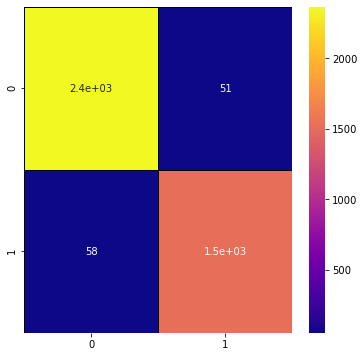

In [14]:
# Confusion Matrix of SVM
cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True,cmap ='plasma', linecolor ='black', linewidths = 1)